## First calculate MCMC posterior predictions

In [6]:
%pylab inline
from skmonaco import mcmiser
from Chempy.parameter import ModelParameters
from Chempy.cem_function import posterior_function_mcmc_quick
from Chempy.score_function import preload_params_mcmc
from Chempy.plot_mcmc import restructure_chain
a = ModelParameters()
preload = preload_params_mcmc()

Populating the interactive namespace from numpy and matplotlib


In [118]:
from Chempy.wrapper import single_star_optimization
%timeit -r 1 -n 1 single_star_optimization()


['Proto-sun_all']
first minimization for each star separately took:  0 seconds
step  1 of  1000
-3.78556083003 -3.78525064371
calculation so far took 7.414967060089111  seconds
step  2 of  1000
-3.78556083003 -3.78683933665
calculation so far took 8.227137565612793  seconds
step  3 of  1000
-3.78556083003 -3.79481582188
calculation so far took 8.933692216873169  seconds
step  4 of  1000
-3.78556083003 -3.79988467547
calculation so far took 9.56412935256958  seconds
step  5 of  1000
-3.78556083003 -3.80329476328
calculation so far took 10.221569299697876  seconds
step  6 of  1000
-3.78556083003 -3.81780466625
calculation so far took 10.94770097732544  seconds
step  7 of  1000
-3.78556083003 -3.8530617453
calculation so far took 11.687074184417725  seconds
step  8 of  1000
-3.78556083003 -3.92438015274
calculation so far took 12.391682386398315  seconds
step  9 of  1000
-3.78556083003 -4.12329878272
calculation so far took 13.111915349960327  seconds
step  10 of  1000
-3.78556083003 -4.2

In [120]:
restructure_chain('mcmc/')
positions = np.load('mcmc/posteriorPDF.npy')
init_param = []
for j in range(len(a.p0)):
    init_param.append(np.percentile(positions[:,j],50))
print(init_param)

blob shape =  (64, 303, 28, 1) probably some runs did not return results and were stored anyway.
The chain has a length of 303 iterations, each iteration having 64 evaluations/walkers
Mean posteriors at the beginning and the end of the chain:
-6.33783516965 -3.78556083003
Mean posteriors after the burn-in tail is cut out:
-6.33783516965 -6.0193516854
We are left with a sample of 4992 posterior evaluations from the converged MCMC chain
We have 4992 iterations good enough posterior, their posteriors range from
-3.33529045108 -18.2584598315
Highest posterior was obtained at parameters:  [[-2.39047741 -2.95348726 -0.87547959 -0.27628465  0.58104929  0.48838231]]
Number of unique posterior values:  2643
Inferred marginalized parameter distributions are:
0 -2.32466120785 +- 0.142727513241
1 -2.96972076692 +- 0.190290734879
2 -0.792220173461 +- 0.294893901937
3 -0.303418903691 +- 0.283194319937
4 0.544174421782 +- 0.101659287146
5 0.49383682827 +- 0.100768782775
[-2.3286866137456554, -2.97139

In [146]:
# Define function to return posterior predictions (must be exponentiated)
def posterior(theta):
    a = ModelParameters()
    post,_ = posterior_function_mcmc_quick(theta,a,preload)
    posterior = np.exp(post)
    return posterior

sigma = [] # Read prior sigma from parameter file
for i,param_name in enumerate(a.to_optimize):
    sigma.append(a.priors.get(param_name)[1])
sigma = np.array(sigma)

In [19]:
Nsamples = [10000,10000,100000] # No MC samples
Nsigma = [2,2.5,3,3.5] # Width in parameter space
j = 0
integral = []
integral_err = []
for i in range(len(Nsigma)):
    print('Calculating integral %d of %d' %(i+1,len(Nsigma)))
    result,error = mcmiser(posterior,npoints=Nsamples[j],xl=init_param-Nsigma[i]*sigma,xu=init_param+Nsigma[i]*sigma)
    integral.append(result)
    integral_err.append(error)

Calculating integral 1 of 4
Calculating integral 2 of 4
Calculating integral 3 of 4
Calculating integral 4 of 4


<Container object of 3 artists>

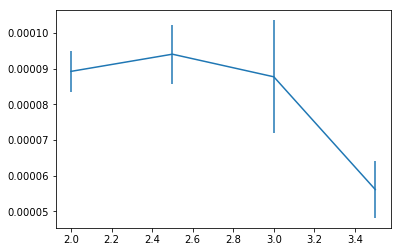

In [20]:
plt.errorbar(Nsigma,integral,yerr=integral_err)

In [22]:
ratio = posterior(init_param)/posterior(init_param+sigma)
print(ratio)

433.082932728


In [49]:
factor = np.sqrt(1./np.log(ratio)*np.dot(sigma,sigma.T)/2)

In [44]:
d1 = []
d2 = []
d3 = []
from scipy.stats import norm
Nsigma = 3
for i in range(5000):
    param = random.uniform(np.array(init_param)-Nsigma*np.array(sigma),np.array(init_param)+Nsigma*np.array(sigma),size=6)
    param[2] = init_param[2]
    param[3] = init_param[3]
    param[4] = init_param[4]
    param[5] = init_param[5]
    post,_ = posterior_function_mcmc_quick(param,a,preload)
    posterior = np.exp(post)
    d1.append(param[0])
    d2.append(param[1])
    dis = np.sqrt(np.dot(param-init_param,(param-init_param).T))
    d3.append(posterior/norm.pdf(dis,scale=0.18))
    if i%100==0:
        print(i)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


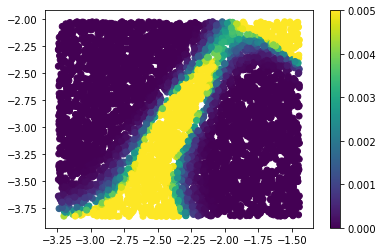

In [48]:
plt.scatter(d1,d2,c=(d3),vmax=0.005)
plt.colorbar()

In [ ]:
from skmonaco import mcimport
skmonaco.mcimport(posterior(theta), npoints, distribution, args=(), dist_kwargs={}, rng=None, nprocs=1, seed=None, batch_size=None, weight=1.0)

<Container object of 3 artists>

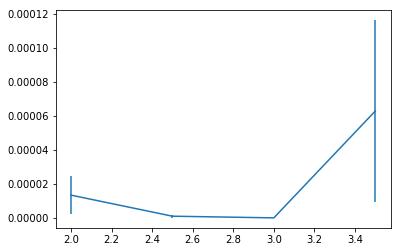

In [120]:
plt.errorbar(Nsigma,integral,yerr=integral_err)

In [105]:
#factor = scinorm(a.p0,mean=init_param,cov=cov)
init_param

[-2.3427591451742913,
 -2.9267582127139948,
 -0.85695676162089884,
 -0.21844682387518691,
 0.55496905981343092,
 0.49045726379122279]

In [117]:
posterior_mod(init_param+np.array([0.1,0.1,0.1,0.1,0.1,0.1]))

1.3850461364156517

In [118]:
posterior_mod(init_param)

4.6260788077632808

In [135]:
Nsigma = 3
d1 = []
d2 = []
d3 = []
for i in range(5000):
    param = random.uniform(np.array(init_param)-Nsigma*np.array(sigma),np.array(init_param)+Nsigma*np.array(sigma),size=6)
    param[2] = init_param[2]
    param[3] = init_param[3]
    param[4] = init_param[4]
    param[5] = init_param[5]
    posterior2 = posterior_mod(param)
    d1.append(param[0])
    d2.append(param[1])
    d3.append(posterior2)
    if i%100==0:
        print(i)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


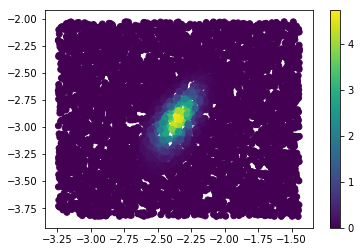

In [139]:
plt.scatter(d1,d2,c=(d3))
plt.colorbar()

In [165]:
cov = np.zeros((len(init_param),len(init_param)))
for i in range(len(init_param)):
    param = np.copy(init_param)
    param[i] = init_param[i]+sigma[i] # Change by 1 sigma in this direction
    factor = posterior(np.array(init_param))/posterior(np.array(param))
    cov[i,i] = np.sqrt(sigma[i]**2/(2*np.log(factor)))

In [9]:
%pylab inline
#from skmonaco import mcmiser
from Chempy.parameter import ModelParameters
from Chempy.cem_function import posterior_function_mcmc_quick
from Chempy.score_function import preload_params_mcmc
from Chempy.plot_mcmc import restructure_chain
a = ModelParameters()
preload = preload_params_mcmc()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [82]:
from scipy.stats import multivariate_normal as scinorm
from numpy.random import multivariate_normal as numnorm

sigma = [] # Read prior sigma from parameter file
for i,param_name in enumerate(a.to_optimize):
    sigma.append(a.priors.get(param_name)[1])
sigma = np.array(sigma)

# Define function to return posterior predictions (must be exponentiated)
def posterior(theta):
    a = ModelParameters()
    post,_ = posterior_function_mcmc_quick(theta,a,preload)
    posterior = np.exp(post)
    return posterior

def posterior_mod(theta):
    return posterior(theta)/gauss_factor(theta)

def gauss_factor(theta):
    return scinorm.pdf(theta,mean=np.array(init_param),cov=cov)

def dist(size):
    # Distribution function
    mean = np.array(init_param)
    return numnorm(mean,cov,size=size)

# factor is the width of the posterior distribution....

In [135]:
cov = np.zeros((len(init_param),len(init_param)))
for i in range(len(init_param)):
    param = np.copy(init_param)
    param[i] = np.copy(init_param[i])+2*sigma[i] # Change by 1 sigma in this direction
    factor = posterior(np.array(init_param))/posterior(np.array(param))
    cov[i,i] = 1.2**2*(2*sigma[i]**2/(np.log(factor))) # np.sqrt()?
# Using 2 sigma at moment, 1.21 factor widens it slightly by 10% to ensure gaussian is wider than posterior

In [136]:
for i in range(len(init_param)):
    param = np.copy(init_param)
    param[i] = np.copy(init_param[i])+2*sigma[i] # Change by 1 sigma in this direction


In [137]:
posterior_mod(param)-posterior_mod(init_param)

-0.00023795694146097748

In [138]:
from skmonaco import mcimport
Nsamples = [500,10000,100000, 50000] # No MC samples
Nsigma = [2,2.5,3,3.5] # Width in parameter space
j = 0
integral = []
integral_err = []

for j in range(len(Nsamples)):
    print('Calculating integral %d of %d' %(j+1,len(Nsamples)))
    result,error = mcimport(posterior_mod,Nsamples[j],dist)
    integral.append(result)
    integral_err.append(error)

ImportError: No module named 'skmonaco'

In [139]:
plt.errorbar(Nsamples,integral,yerr=integral_err)

NameError: name 'Nsamples' is not defined

In [140]:
Nsigma = 3
d1 = []
d2 = []
d3 = []
for i in range(2000):
    param = random.uniform(np.array(init_param)-Nsigma*np.array(sigma),np.array(init_param)+Nsigma*np.array(sigma),size=6)
    param[2] = init_param[2]
    param[3] = init_param[3]
    param[4] = init_param[4]
    param[5] = init_param[5]
    posterior2 = posterior_mod(param)
    d1.append(param[0])
    d2.append(param[1])
    d3.append(posterior2)
    if i%100==0:
        print(i)


0
100
200
300


KeyboardInterrupt: 

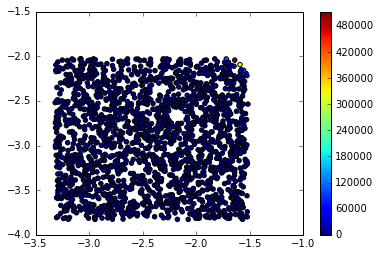

In [76]:
plt.scatter(d1,d2,c=d3) #,vmin=0.01,vmax=10) #vmax = 10)
plt.colorbar()

In [78]:
posterior(init_param+2*sigma)/posterior(init_param)

3.205824272116973e-07

In [79]:
posterior_mod(init_param+2*sigma)/posterior_mod(init_param)

939608.56989029434

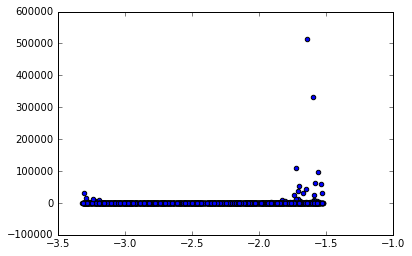

In [81]:
plt.scatter(d1,d3)

In [141]:
Nsigma = 3
x=[]
post=[]
gauss = []
for i in range(2000):
    param = random.uniform(np.array(init_param)-Nsigma*np.array(sigma),np.array(init_param)+Nsigma*np.array(sigma),size=6)
    param[1] = init_param[1]
    param[2] = init_param[2]
    param[3] = init_param[3]
    param[4] = init_param[4]
    param[5] = init_param[5]
    x.append(param[0])
    post.append(posterior(param))
    gauss.append(gauss_factor(param))
    if i%100==0:
        print(i)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


0.037982465402190108

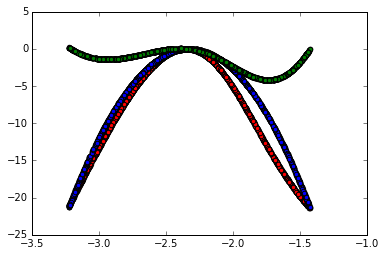

In [142]:
plt.clf()
plt.scatter(x,np.log(post/max(post)),c='r')
plt.scatter(x,np.log(gauss/max(gauss)),c='b')
plt.scatter(x,np.log(np.array(post)/np.array(gauss)/max(post)*max(gauss)),c='g')
#plt.xlim([-1.6,-1.5])
max(post)